# Introduction

This notebooks shows how to use GENNI with the methods that is provided with the package. After generating an experiments (how this is done can be found in the `README.md` of the package) we show how to load, generate grids and plot the equivalence classes of functionally equal neural network parameters.

In [7]:
from pathlib import Path

import umap

from genni.experiment import (
    extract_experiment,
    create_experiment_folder_and_hyperparam_id,
    create_data_loader,
    plot_surface,
    plot_contour,
    setup_eps_equivalent_set,
    plot_3d,
    setup_umap,
    plot_umap,
)
from genni.save_load import cache_data, load_cached_data

%matplotlib inline

# Load experiment

For this to work you need to have generated an experiment. Have a look at the `README.md` in the GENNI base directory on how to do this.

In [24]:
genni_exp_dir, exp_dict = extract_experiment(Path("..") / "genni.yml")
experiment_folder, exp_id = create_experiment_folder_and_hyperparam_id(
    genni_exp_dir, exp_dict, experiment_idx=0
)

In [25]:
data_loader, cfg = create_data_loader(experiment_folder, exp_id=exp_id)

# Plot in 2D

## Generate grid from experiment

We provide setup functions that generate the necessary grids and data for plotting.

In [27]:
# Loads and prepares the functional distance plot in 2d given the experiment specified
# Check the documentation of the function for more information
vals, grid_arr, vals_filter, meta_data = setup_eps_equivalent_set(
    experiment_folder,
    exp_id,
    data_loader,
    step=1001,
    center_vector_id=0,
    basis_vector_ids=[1, 2],
    grid_bound=[-20, 20],
    num_inter_models=20,
    filter_threshold=1,
)

100%|██████████| 400/400 [00:14<00:00, 28.48it/s]


In [28]:
fig_surf = plot_surface(vals, grid_arr, meta_data, update_layout=False)
fig_surf.show()

In [29]:
fig_cont = plot_contour(vals, grid_arr, meta_data, update_layout=False)
fig_cont.show()

# Plot in 3D

In [ ]:
vals, grid_coeffs, vals_filter, meta_data = setup_eps_equivalent_set(
    experiment_folder,
    exp_id,
    data_loader,
    step=1001,
    center_vector_id=0,
    basis_vector_ids=[1, 2, 3],
    grid_bound=[-2, 2],
    num_inter_models=20,
    filter_threshold=0.025,
)

 20%|██        | 1609/8000 [00:56<03:42, 28.73it/s]

In [8]:
fig_3d = plot_3d(vals[vals_filter], grid_coeffs[vals_filter])
fig_3d.show()

### UMAP Plot

Plot the 2d UMAP projection of the values GENNI output at optimisation step `step`.

In [9]:
# setup_umap can only be called after setup_3d
umap_model = umap.UMAP(n_neighbors=20, min_dist=0.5, metric="euclidean", verbose=True)
dataset, labels, projections = setup_umap(
    umap_model, vals_filter, vals, meta_data, experiment_folder, exp_id
)

8000it [00:02, 3323.27it/s]


UMAP(min_dist=0.5, n_neighbors=20, verbose=True)
Construct fuzzy simplicial set
Sat Nov 28 20:33:49 2020 Finding Nearest Neighbors
Sat Nov 28 20:33:50 2020 Finished Nearest Neighbor Search
Sat Nov 28 20:33:51 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sat Nov 28 20:33:53 2020 Finished embedding


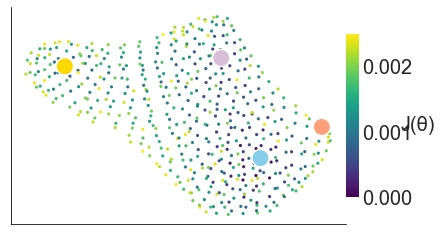

In [10]:
fig, ax = plot_umap(dataset, labels, projections)